# Cryptocurrency Market Predictor - Recurrent Neural Network

Predicting BTCUSD market

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [2]:
dataset = pd.read_csv('ETHUSD_TechnicalIndicators.csv', nrows=5000)
dataset.tail(2)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
4998,291.995,291.995,0.018774,291.99,5.799337,291.99,292.0,110.306063,27.558405,0.01
4999,291.995,291.995,0.010257,291.99,5.799337,291.99,292.0,581.240510,27.558405,0.01


#### Normalize

In [3]:
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm.head(3)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
0,-0.383638,-0.356395,-0.000954,-0.989820,-0.017118,-0.397007,-0.369611,-0.060744,0.241710,0.176219
1,-0.382809,-0.359712,-0.000779,-0.989820,-0.017118,-0.398663,-0.366294,-0.013768,-0.089702,0.207469
2,-0.382809,-0.359712,-0.000779,-0.006949,-0.016206,-0.398663,-0.366294,-0.013768,-0.089702,0.207469


## Hyperparams

In [4]:
num_epochs = 100

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 10 #The size of the sequence

state_size = 25 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 1000

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 5000
The current configuration gives us 500 batches of 1 observations each one looking 10 steps in the past


## Train-Test split

In [5]:
datasetTrain = datasetNorm[dataset.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [6]:
datasetTrain.head(2)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
0,-0.383638,-0.356395,-0.000954,-0.98982,-0.017118,-0.397007,-0.369611,-0.060744,0.241710,0.176219
1,-0.382809,-0.359712,-0.000779,-0.98982,-0.017118,-0.398663,-0.366294,-0.013768,-0.089702,0.207469


In [7]:
datasetTest.head(2)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
4000,0.115533,0.129508,0.067216,0.003321,-0.017118,0.094715,0.136194,-0.045321,-0.094397,0.259552
4001,0.115533,0.129508,0.061548,0.003321,-0.017107,0.094715,0.136194,-0.045321,-0.094397,0.259552


In [8]:
#Pick appropriate columns to train
xTrain = datasetTrain[['Price','b1','a1','Spread']].as_matrix()
yTrain = datasetTrain['PriceTarget'].as_matrix()

In [9]:
print(xTrain[0:3],'\n',yTrain[0:3])

[[-0.38363798 -0.39700695 -0.36961061  0.17621875]
 [-0.38280879 -0.39866258 -0.36629386  0.20746875]
 [-0.38280879 -0.39866258 -0.36629386  0.20746875]] 
 [-0.35639536 -0.35971211 -0.35971211]


In [10]:
#Pick appropriate columns to test
xTest = datasetTest[['Price','b1','a1','Spread']].as_matrix()
yTest = datasetTest['PriceTarget'].as_matrix()

In [11]:
print(xTest[0:3],'\n',yTest[0:3])

[[ 0.11553284  0.0947149   0.1361937   0.25955208]
 [ 0.11553284  0.0947149   0.1361937   0.25955208]
 [ 0.11719121  0.09802616  0.1361937   0.23871875]] 
 [ 0.12950846  0.12950846  0.12867927]


## Visualize starting price data

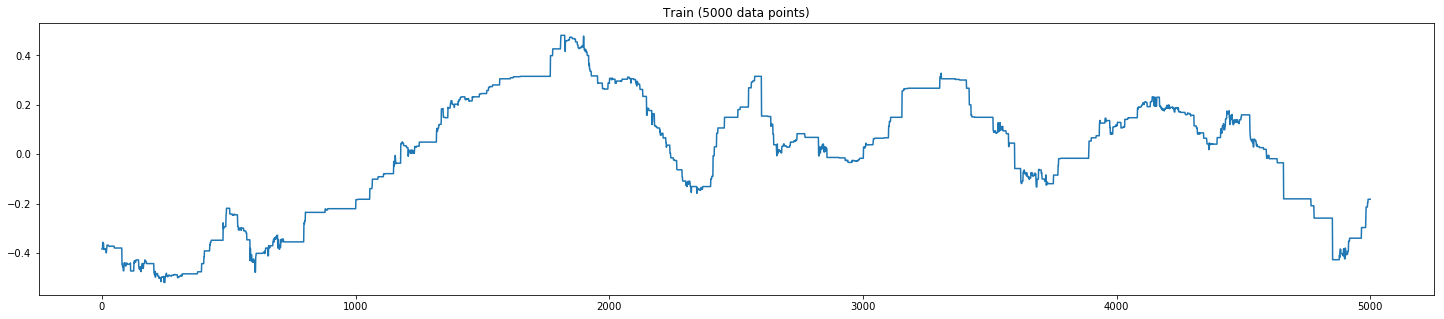

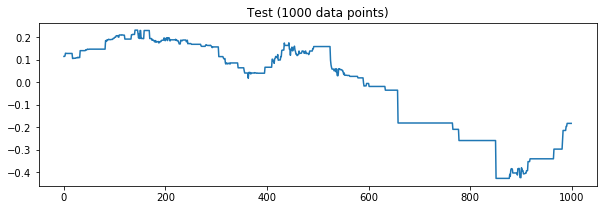

In [12]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

## Placeholders

In [13]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases
Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output

We need 2 pairs of W and b

In [14]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack

In [15]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [16]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [17]:
states_series = tf.transpose(states_series,[1,0,2])

## Backward pass - Output

In [18]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Weights and bias out

In [19]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

## Prediction, Loss & Optimizer

In [20]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [21]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

C:\Users\Jason\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [22]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 200 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 0.193065
Step 200 - Loss: 0.005271
Step 400 - Loss: 0.000022
Epoch 1
Step 0 - Loss: 0.014148
Step 200 - Loss: 0.000015
Step 400 - Loss: 0.000485
Epoch 2
Step 0 - Loss: 0.003822
Step 200 - Loss: 0.000055
Step 400 - Loss: 0.000017
Epoch 3
Step 0 - Loss: 0.007135
Step 200 - Loss: 0.000005
Step 400 - Loss: 0.000534
Epoch 4
Step 0 - Loss: 0.008760
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.001255
Epoch 5
Step 0 - Loss: 0.010005
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.001368
Epoch 6
Step 0 - Loss: 0.011551
Step 200 - Loss: 0.000006
Step 400 - Loss: 0.001420
Epoch 7
Step 0 - Loss: 0.012583
Step 200 - Loss: 0.000014
Step 400 - Loss: 0.001405
Epoch 8
Step 0 - Loss: 0.012791
Step 200 - Loss: 0.000016
Step 400 - Loss: 0.001307
Epoch 9
Step 0 - Loss: 0.012500
Step 200 - Loss: 0.000010
Step 400 - Loss: 0.001158
Epoch 10
Step 0 - Loss: 0.012035
Step 200 - Loss: 0.000002
Step 400 - Loss: 0.000974
Epoch 11
Step 0 - Loss: 0.011514
Step 200 - Loss: 0.000001
Step 400 - Loss:

Step 400 - Loss: 0.000001
Epoch 97
Step 0 - Loss: 0.000311
Step 200 - Loss: 0.000421
Step 400 - Loss: 0.000003
Epoch 98
Step 0 - Loss: 0.000283
Step 200 - Loss: 0.000465
Step 400 - Loss: 0.000002
Epoch 99
Step 0 - Loss: 0.000389
Step 200 - Loss: 0.000457
Step 400 - Loss: 0.000002


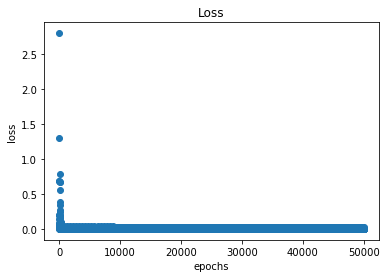

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

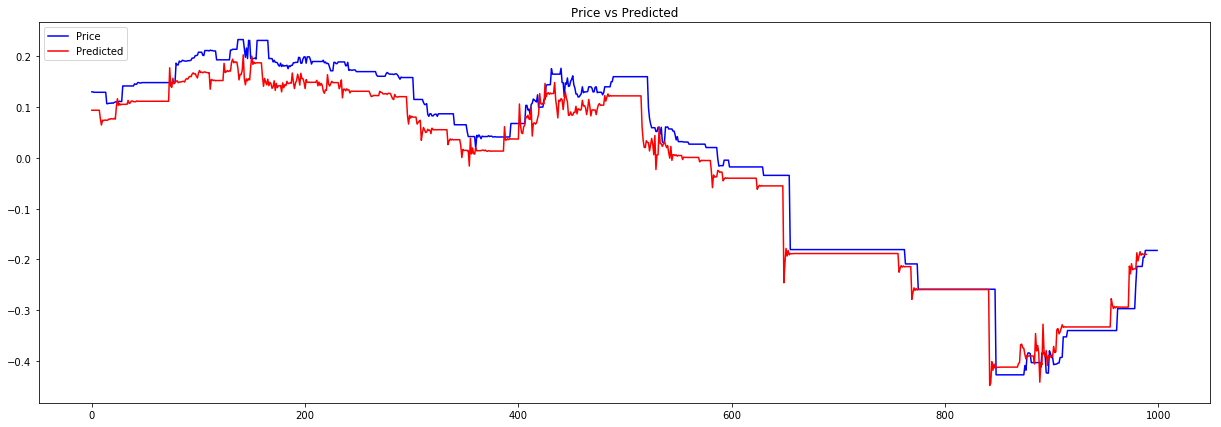

In [24]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()